<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/Natalia/JDI_GC_explore_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

In [ ]:
!pip install patchify -qq

In [ ]:
import patchify

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  28829      0 --:--:-- --:--:-- --:--:-- 28505
OK
26 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.5_amd64.deb ...
Unpacking gcsfuse (0.41.5) ...
Setting up gcsfuse (0.41.5) ...


In [ ]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/08/23 15:11:36.216865 Start gcsfuse/0.41.5 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/08/23 15:11:36.237300 Opening GCS connection...
2022/08/23 15:11:37.344420 Mounting file system "justdiggit-drone"...
2022/08/23 15:11:37.379331 File system has been successfully mounted.


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load example DSM data


In [ ]:
year = '2019'
village = 'bumila'
DRIVE_path = '/content/drive/MyDrive/AI for Trees Share/01. Data'
example_DSM_path = f'{DRIVE_path}/justdiggit-drone-data/DSM/converted/{village}.tiff'

In [ ]:
full_height_map = gdal.Open(example_DSM_path).ReadAsArray()

In [ ]:
full_height_map.shape

(9266, 9469)

## Count the number of labeled data

In [ ]:
# list cases where we have the height maps
villages_with_height_data = ["bumila", "chaludewa", "ikengwa", "kisima", "loo", "mapango"]
all_tiles = []
for village in villages_with_height_data:
  tiles = glob.glob(f'justdiggit-drone-data/label_sample/{village}_year_2019_tile_*.png')
  print(village + ": " + str(len(tiles)))
  all_tiles += tiles

bumila: 98
chaludewa: 94
ikengwa: 91
kisima: 95
loo: 73
mapango: 28


In [ ]:
len(all_tiles)

479

## Compare full RGB images to full height maps

In [ ]:
full_rgb_path = 'justdiggit-drone-data/rdp-2019/bumila/red_band.tif'

In [ ]:
full_image = mpimg.imread(full_rgb_path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (147435201 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


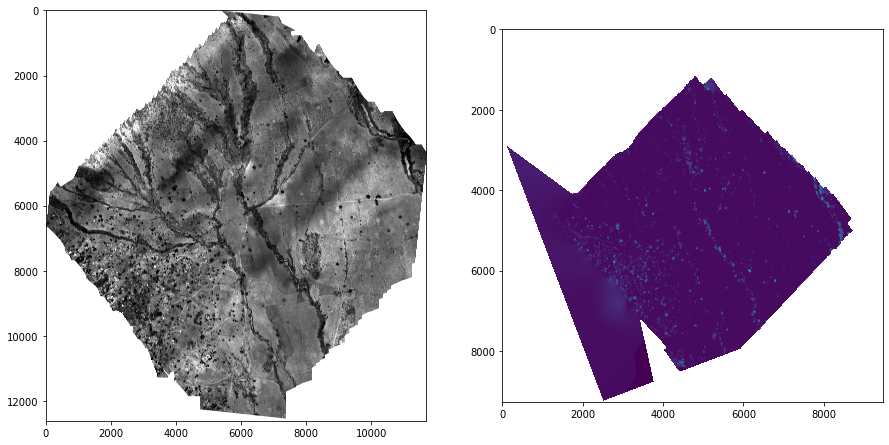

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,15))
axes[0].imshow(full_image)
axes[1].imshow(full_height_map)

In [ ]:
print("Height map size: ", full_height_map.shape)
print("RGB size: ", full_image.shape)

Height map size:  (9266, 9469)
RGB size:  (12611, 11691, 4)


In [ ]:
full_image_gdal = gdal.Open(full_rgb_path)

In [ ]:
im_gt = full_image_gdal.GetGeoTransform()
im_gt

(36.558206366685,
 1.1460399999999595e-06,
 0.0,
 -6.36249654086055,
 0.0,
 -1.1465499999999812e-06)

In [ ]:
full_HM_gdal = gdal.Open(example_DSM_path)
hm_gt = full_HM_gdal.GetGeoTransform()
hm_gt

(36.5558887427416,
 1.9151199999997304e-06,
 0.0,
 -6.36040185859351,
 0.0,
 -1.915960000000046e-06)

# Exploring annotations

In [ ]:
!pip install geopandas -qq

     |████████████████████████████████| 1.0 MB 6.9 MB/s 
     |████████████████████████████████| 16.7 MB 35.2 MB/s 
     |████████████████████████████████| 6.3 MB 57.9 MB/s 


In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, Point

In [ ]:
ANNO_PATH = 'justdiggit-drone-data/evaluation/annotations/version-1'

In [ ]:
shp_file = f"{ANNO_PATH}/bumila_2019_annotations.shp"

In [ ]:
#read in shapefile into a GeoDataFrame
gdf = gpd.read_file(shp_file)

In [ ]:
gdf.head(n=2)

,Tile,Location,Year,label_idx,Class,ID,geometry
0,./data/label_sample/bumila_year_2019_tile_1000...,bumila,2019,0,0.0,bumila_2019,"POLYGON ((36.56085 -6.36676, 36.56085 -6.36676..."
1,./data/label_sample/bumila_year_2019_tile_1000...,bumila,2019,1,0.0,bumila_2019,"POLYGON ((36.56087 -6.36677, 36.56087 -6.36677..."


In [ ]:
gdf["Tile"].nunique()

89

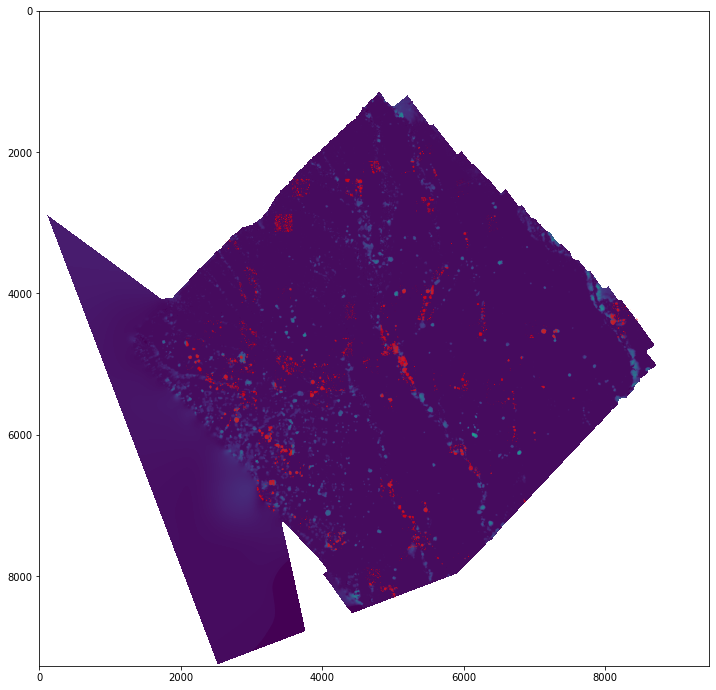

In [ ]:
img = full_HM_gdal
img_array = img.ReadAsArray()
geotransform = img.GetGeoTransform()

XSize = img.RasterXSize #image length in X
YSize = img.RasterYSize #image length in Y

#calculate latitude & longitude arrays
lat = np.arange(geotransform[3],geotransform[3] + YSize*geotransform[-1],geotransform[-1])
lon = np.arange(geotransform[0],geotransform[0] + YSize*geotransform[1],geotransform[1])


#base image
fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_array)

#we'll also write these new pixel-based polygons to a new GeoDataFrame for safe-keeping.
pixel_gdf = gdf.copy()
i=0
for geom in gdf.geometry:

    #get coordinates of each tree crown
    xs, ys = geom.exterior.xy

    #find the pixel equivalent
    x_pixel = np.array([np.where(abs(lon-x) == min(abs(lon-x)))[0] for x in xs])
    y_pixel = np.array([np.where(abs(lat-y) == min(abs(lat-y)))[0] for y in ys])

    #draw the tree crown
    ax.fill(x_pixel, y_pixel, alpha=0.7, fc='r', ec='none')

    #save the converted polygons as geometries
    coords = []
    for k in range(len(x_pixel)):
      coords.append(Point(x_pixel[k], y_pixel[k]))

    pixel_gdf.geometry.iloc[i] = Polygon(coords)
    i+=1


## Extracting height data compatible with the annotations

The RGB images vary from the height maps in terms of size, resolution and coverage. The annotations were apparently created for specific tiles of the RGB data. These tiles are saved as png files, which means they are no longer georeferenced. The task now is aligning them with the height data to create height tiles compatible with the annotation masks. 


### The code below was used to generate the RGB tiles

Idea: modify this code to save the tiles as .tif to keep the geo references, then use those references to cut out the same areas from the height maps

In [ ]:
"""
import gdal
import os

# Cut large geotiff in pngs with corresponding files including geocoordinates
list_files = []
for file in list_files:
  in_path = file

  location = 'chaludewa'
  year = '2019'
 
  out_path = f'/content/data/processed/{location}/{year}/'

  output_filename = f'{location}_year_{year}_tile_'
  
  tile_size_x = 1000
  tile_size_y = 1000
  
  ds = gdal.Open(in_path)
  band = ds.GetRasterBand(1)
  xsize = band.XSize
  ysize = band.YSize
  
  for i in range(0, xsize, tile_size_x):
      for j in range(0, ysize, tile_size_y):
         
          # command line command to run:         
          com_string = "gdal_translate -of PNG -ot Byte -srcwin " + str(i)+ ", " 
          + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " 
          + str(in_path) + " " + str(out_path) + str(output_filename) + str(i) 
          + "_" + str(j) + ".png"

          print(output_filename +str(i) + "_" + str(j))
          os.system(com_string)
"""